# Machine Learning and Data Science (MALDSAC) 2024

## Weight Initialisation in Pytorch
---------------

## Import Libraries

In [ ]:
import time as time
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch as torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

## Settings and Dataset

In [ ]:
# Global Model Settings
random_seed = 1
batch_size = 32
num_epochs = 5
num_epochs_logs = 50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# MNIST Dataset
# Training Set
train_dataset = datasets.MNIST(root='dataset',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

In [ ]:
# MNIST Dataset
# Test Set
test_dataset = datasets.MNIST(root='dataset',
                              train=False,
                              transform=transforms.ToTensor())


test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [ ]:
# Checking the dataset's dimensions (batch size)
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## Sigmoid Activation with Sofmax output and Cross Entropy Loss

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.num_classes = num_classes

        # Hidden layer configuration
        self.fc1 = torch.nn.Linear(num_features, num_hidden) # initialize linear activation for hidden layer
        #self.fc1.weight.detach().normal_(0.0, 0.1) # initialize weights from normal distribution [0.0, 0.1]
        #self.fc1.bias.detach().zero_() # initialize bias to zero
        #torch.nn.init.normal_(self.fc1.weight, mean=0, std=1)
        #torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc1.weight)

        # Non-linear activation function
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()

        # Output layer configuration
        self.fc2 = torch.nn.Linear(num_hidden, num_classes) # initialize linear activation for output layer
        #self.fc2.weight.detach().normal_(0.0, 0.1) # initialize weights from normal distribution [0.0, 0.1]
        #self.fc2.bias.detach().zero_() # initialize bias to zero
        #torch.nn.init.normal_(self.fc2.weight, mean=0, std=1)
        #torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.fc1(x) # do forward propagation on x for the first hidden layer and obtain activations.

        #out = torch.sigmoid(out) # apply sigmoid function on the preactivations of the first hidden layer (previous output).
        #out = self.tanh(out) # apply tanh function on the preactivations of the first hidden layer (previous output).
        out = self.relu(out) # apply Relu function on the preactivations of the first hidden layer (previous output).

        logits = self.fc2(out) # do forward propagation for the second hidden layer.
        probas = torch.softmax(logits, dim=1) # apply softmax functions on logits to obtain predictions.
        return logits, probas

In [ ]:
# Initialize Model
torch.manual_seed(random_seed)
model = MultiLayerPerceptron(num_features=28*28,
                      num_hidden=100,
                      num_classes=10)

In [ ]:
# Putting model to device (GPU/CPU)
model = model.to(device)

In [ ]:
# Initilizing SGD optimizer with learning_rate of 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            a1, a2 = model.forward(features)
            predicted_labels = torch.argmax(a2, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

In [ ]:
# Computing Cross Entropy Loss on minibatches.
def compute_error_loss(model, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader): # for each pairs ((x^[i], y^[i]), ..., (x^[i+k], y^[i+k])) in minibatch
            features = features.view(-1, 28*28).to(device) # Move features to device and vectorize them
            targets = targets.to(device) # Put targets to device
            logits, probas = model.forward(features) # Obtain logits and probas from model
            loss = F.nll_loss(torch.log(probas), targets)
            # loss = F.cross_entropy(logits, targets)
            curr_loss += loss # Accumulate current loss
        curr_loss = float(curr_loss)/cnt # Normalize loss over total of minibatches
        return curr_loss # Return loss

In [ ]:
# Doing Stochastic Gradient Descent on minibatches
start_time = time.time()
minibatch_cost = []
epoch_cost = []

for epoch in range(num_epochs):

    # Setting model in training modus
    model.train()

    # Iterating over dataset
    for batch_idx, (features, targets) in enumerate(train_loader):

        # Putting data (feats, targets) into device
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        # Forward Propagation
        logits, probas = model(features)

        cost = F.nll_loss(torch.log(probas), targets)

        # Clear accumulated gradients from previous epochs
        optimizer.zero_grad()

        # Backward propagation
        cost.backward()

        # Add minibatch cost
        minibatch_cost.append(cost)

        # Update model parameters
        optimizer.step()

        # History
        if not batch_idx % num_epochs_logs:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f '
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost))

    cost = compute_error_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d | Train Cost: %.4f | Accuracy: %.4f%%' % (
            epoch+1, num_epochs, cost,
            compute_accuracy(model, train_loader)))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/1875 | Cost: 2.2970 
Epoch: 001/005 | Batch 050/1875 | Cost: 0.6356 
Epoch: 001/005 | Batch 100/1875 | Cost: 0.4793 
Epoch: 001/005 | Batch 150/1875 | Cost: 0.3613 
Epoch: 001/005 | Batch 200/1875 | Cost: 0.4933 
Epoch: 001/005 | Batch 250/1875 | Cost: 0.3634 
Epoch: 001/005 | Batch 300/1875 | Cost: 0.3677 
Epoch: 001/005 | Batch 350/1875 | Cost: 0.3532 
Epoch: 001/005 | Batch 400/1875 | Cost: 0.3369 
Epoch: 001/005 | Batch 450/1875 | Cost: 0.3307 
Epoch: 001/005 | Batch 500/1875 | Cost: 0.2348 
Epoch: 001/005 | Batch 550/1875 | Cost: 0.2138 
Epoch: 001/005 | Batch 600/1875 | Cost: 0.2831 
Epoch: 001/005 | Batch 650/1875 | Cost: 0.2371 
Epoch: 001/005 | Batch 700/1875 | Cost: 0.2133 
Epoch: 001/005 | Batch 750/1875 | Cost: 0.3406 
Epoch: 001/005 | Batch 800/1875 | Cost: 0.3054 
Epoch: 001/005 | Batch 850/1875 | Cost: 0.3023 
Epoch: 001/005 | Batch 900/1875 | Cost: 0.3680 
Epoch: 001/005 | Batch 950/1875 | Cost: 0.2962 
Epoch: 001/005 | Batch 1000/1875 | Cost:

Epoch: 005/005 | Batch 550/1875 | Cost: 0.0357 
Epoch: 005/005 | Batch 600/1875 | Cost: 0.1659 
Epoch: 005/005 | Batch 650/1875 | Cost: 0.0382 
Epoch: 005/005 | Batch 700/1875 | Cost: 0.0292 
Epoch: 005/005 | Batch 750/1875 | Cost: 0.0408 
Epoch: 005/005 | Batch 800/1875 | Cost: 0.0541 
Epoch: 005/005 | Batch 850/1875 | Cost: 0.1736 
Epoch: 005/005 | Batch 900/1875 | Cost: 0.0502 
Epoch: 005/005 | Batch 950/1875 | Cost: 0.0554 
Epoch: 005/005 | Batch 1000/1875 | Cost: 0.0698 
Epoch: 005/005 | Batch 1050/1875 | Cost: 0.0283 
Epoch: 005/005 | Batch 1100/1875 | Cost: 0.1046 
Epoch: 005/005 | Batch 1150/1875 | Cost: 0.0656 
Epoch: 005/005 | Batch 1200/1875 | Cost: 0.0062 
Epoch: 005/005 | Batch 1250/1875 | Cost: 0.0173 
Epoch: 005/005 | Batch 1300/1875 | Cost: 0.0366 
Epoch: 005/005 | Batch 1350/1875 | Cost: 0.0175 
Epoch: 005/005 | Batch 1400/1875 | Cost: 0.0971 
Epoch: 005/005 | Batch 1450/1875 | Cost: 0.0515 
Epoch: 005/005 | Batch 1500/1875 | Cost: 0.0603 
Epoch: 005/005 | Batch 1550/1

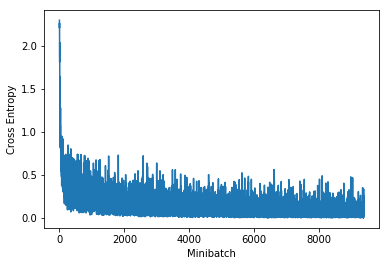

In [ ]:
# Plot minitbatch cost
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

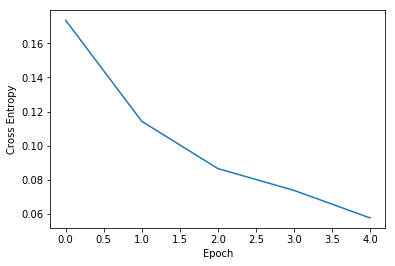

In [ ]:
# Plot epoch cost
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 98.32
Test Accuracy: 97.39
